In [1]:
from scipy.special import digamma
from numpy.linalg import inv
from numpy import log
import numpy as np

import matplotlib.pyplot as plt

from multivariate_util import *

In [2]:
%matplotlib inline

###### Source
The EM Algorithm and Extensions, Pg. 60.

$$
log L_c(\Psi) = log L_{1c}(\Psi) + a(z) \\
$$

where

$$
log L_{1c}(\Psi) = -\frac{np}{2}\ log(2 \pi) - \frac{n}{2} log | \Sigma | -\frac{1}{2} \sum_{j=1}^n u_j (w_j - \mu)^T \Sigma^{-1}(w_j - \mu)
$$

and

$$
a(z) = -n log \Gamma \big(\frac{v}{2} \big) + \frac{nv}{2}log \big( \frac{v}{2} \big) +\frac{v}{2} \sum_{j=1}^n \big[log(u_j) - u_j)\big] - \sum_{j=1}^n log u_j
$$

In [3]:
def log_of_psi():
    n  = len(X)
    u_ = [(_-mu).T.dot(inv(cov).dot(_-mu)) for _ in X]
    return -.5*n*p*log(2 * np.pi) -.5*n*log(np.linalg.det(cov)) - .5 * sum(u_)

In [4]:
def az():
    n  = len(X)
    u_ = [(_-mu).T.dot(inv(cov).dot(_-mu)) for _ in X]
    return -n*log(gamma(df/2.)) + .5*n*df*log(df/2.) + .5*df*(log(u_) - u_).sum() - log(u_).sum()

### Modified version

In [5]:
def log_of_psi():
    n  = len(X)
    u_ = [(_-mu).T.dot(inv(cov).dot(_-mu)) for _ in X]
    return -.5*n*log(np.linalg.det(cov)) - .5 * sum(u_)

In [6]:
def az():
    n  = len(X)
    u_ = [(_-mu).T.dot(inv(cov).dot(_-mu)) for _ in X]
    return -n*log(gamma(df/2.)) + .5*n*df*log(df/2.) + .5*df*(log(u_) - u_).sum()

### Generating sample

In [7]:
mu  = [0,0]
cov = [[1,0], [0,1]]
df  = 10
size = 300

In [8]:
X = multivariate_t_rvs(m=mu, S=cov, df=df, n=size)

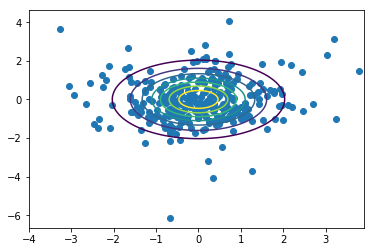

In [9]:
t0 = multivariate_t(mu, cov, df)

x, y = np.mgrid[-4:4:.1, -4:4:.1]
xy = np.column_stack([x.ravel(), y.ravel()])

z0 = []
for _ in xy:
    z0.append(t0.pdf(_))
z0 = np.reshape(z0, x.shape)

plt.scatter(X.T[0], X.T[1])
plt.contour(x, y, z0)

### Estimating Parameters

In [10]:
def find_df(v):
    return -digamma(v/2.) + log(v/2.) + (log(tau) - tau).sum()/len(tau) + 1 + (digamma((v+p)/2.)-log((v+p)/2.))

In [11]:
# My Guesses
mu  = [1, 2]
cov = [[1.5, 0.],[0, 1.5]]
df  = 4
p = 2

psi_likelihood = []
df_likelihood = []
for z in range(200):
    # E-Step 1
    u = []
    for delta in X-mu:
        u.append(delta.dot(inv(cov)).dot(delta))
    u = np.array(u)
    tau = (df + p)/(df + u); tau = tau.reshape(-1, 1)
    tau_sum = tau.sum()
    
    # CM-Step 1
    mu_  = (tau * X).sum(axis=0) / tau_sum

    cov_ = np.array([[0,0], [0,0]], dtype=np.float32)
    for idx, delta in enumerate(X - mu_):
        delta = delta.reshape(-1, 1)
        cov_ += (tau[idx]*delta).dot(delta.T)
    cov_ /= len(tau)
    
    # E-Step 2
    u = []
    for delta in X-mu_:
        u.append(delta.dot(inv(cov_)).dot(delta))
    u = np.array(u)
    tau = (df + p)/(df + u); tau = tau.reshape(-1, 1)
    tau_sum = tau.sum()
    
    # CM-Step 2
    v_ = 0
    my_range = np.arange(df-3, df+3, .001)
    for _ in my_range:
        solution = find_df(_)
        if solution < 0+1e-4 and solution > 0-1e-4:
            #if z % 5 == 0:
            #    print '#%d - %.6f' % (z, _)
            v_ = _
            break
    
    mu  = mu_
    cov = cov_
    df = v_
    
    psi_likelihood.append(log_of_psi())
    df_likelihood.append(az())
    
    if len(psi_likelihood) > 1:
        if psi_likelihood[-1] - psi_likelihood[-2] <= 1e-10:
            break
    
    """
    if len(df_likelihood) == 0:
        df = v_
    elif len(df_likelihood) > 1:
        if df_likelihood[-2] < df_likelihood[-1]:
            df = v_
    """

print mu
print cov
print df

[-0.01097535 -0.09288302]
[[ 0.88104808  0.05002644]
 [ 0.05002644  0.85380828]]
6.31799999999


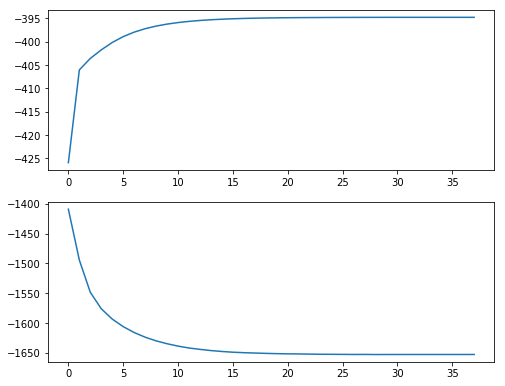

In [12]:
plt.figure(figsize=(8, 10))

plt.subplot(311)
plt.plot(range(len(psi_likelihood)), psi_likelihood)

plt.subplot(312)
plt.plot(range(len(df_likelihood)), df_likelihood)

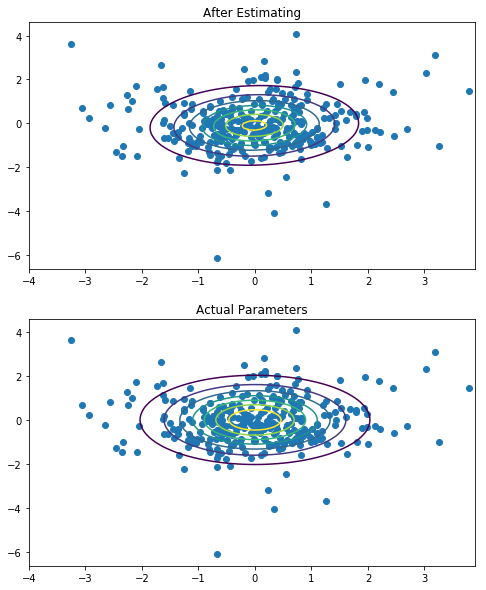

In [13]:
t1 = multivariate_t(mu, cov, df)

x, y = np.mgrid[-4:4:.1, -4:4:.1]
xy = np.column_stack([x.ravel(), y.ravel()])

z1 = []
for _ in xy:
    z1.append(t1.pdf(_))
z1 = np.reshape(z1, x.shape)

plt.figure(figsize=(8, 10))

plt.subplot(211)
plt.title('After Estimating')
plt.scatter(X.T[0], X.T[1])
plt.contour(x, y, z1)

plt.subplot(212)
plt.title('Actual Parameters')
plt.scatter(X.T[0], X.T[1])
plt.contour(x, y, z0)